# **NSFW Classifier - Data Cleaning + Augmentation Experiment**

## **Purpose**

The aim of this notebook is to see the joint effect of data cleaning and data augmentation on accuracy and overfitting. 

Only code is shown here. For a discussion of methodology and results, please refer to the notebook NSFW-resnet50-baseline-with-cleaned-dataset.ipynb

## Setting up the environment

In [ ]:
# Setup Fastai Colab environment
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.all import *
import os

# Some files got mildly corruped during upload to Google Drive.
# This helps avoids some problems down the line
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Set random seed for reproducibility

seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [ ]:
# Verify image folder location
os.listdir("../content/gdrive/My Drive/Datasets")

['NSFW', 'SFW']

In [ ]:
# Create Path object to image folders
path=Path("../content/gdrive/My Drive/Datasets")
path.ls()

(#2) [Path('../content/gdrive/My Drive/Datasets/NSFW'),Path('../content/gdrive/My Drive/Datasets/SFW')]

In [ ]:
print('total NSFW images:', len(os.listdir(os.path.join(path, "NSFW"))))
print('total SFW images:', len(os.listdir(os.path.join(path, "SFW"))))

total NSFW images: 3059
total SFW images: 3110


## Setting up the image dataloader

In [ ]:
# Define input params for data block 

# This sets up a train/validate split of 80/20
splitter=RandomSplitter(valid_pct=0.2, seed=seed) 
# ResNet50 requires an input size of (224, 224, 3)
item_tfms = [Resize(460)]
batch_tfms=aug_transforms(size=224, min_scale=0.75)

In [ ]:
# Create blueprint for dataloader
data_block = DataBlock(
                  blocks=[ImageBlock, CategoryBlock],
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=splitter,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

In [ ]:
# Create dataloader with batch size = 64 
dls = data_block.dataloaders(path, bs=64)

In [ ]:
# Run this cell at your own peril!
dls.show_batch()

## Training 

In [ ]:
# Prevents getting disconnected, use only when training in Colab
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
# Instantiate a pre-trained model by substituting the top FC layer with two new ones. (Happens under the hood)
learn = cnn_learner(dls, resnet50, metrics=accuracy)
# Train the new FC layers for 20 epochs
learn.fine_tune(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.419611,0.253206,0.918086,01:52


epoch,train_loss,valid_loss,accuracy,time
0,0.183145,0.155692,0.946472,01:58
1,0.120797,0.143683,0.953771,01:57
2,0.101506,0.212774,0.939173,01:57
3,0.093320,0.174299,0.940795,01:57
4,0.102097,0.170852,0.944039,01:55
5,0.094710,0.141616,0.951338,01:59
6,0.080680,0.158000,0.947283,01:59
7,0.084956,0.137192,0.951338,01:58
8,0.081117,0.136709,0.953771,01:56
9,0.065478,0.179990,0.943228,01:57


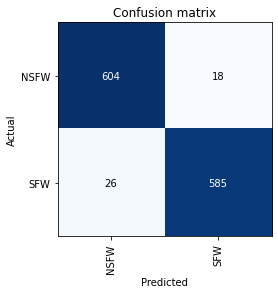

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Only for the brave! 
interp.plot_top_losses(9, nrows=3)